In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

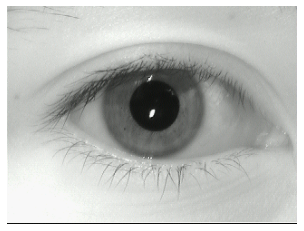

In [31]:
path = 'img/zulaikahr2.bmp'
path = 'IMG_026_L_4.jpg'
path = 'zulaikahr2.bmp'
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

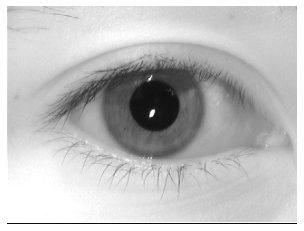

In [32]:
# Covert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.show()

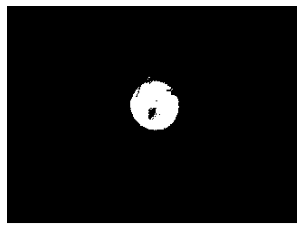

In [33]:
# Binarize to find the pupil
_, binary = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY_INV)
plt.imshow(binary, cmap='gray')
plt.axis('off')
plt.show()

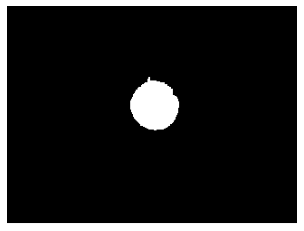

In [34]:
#Closing
kernel = np.ones((5,5), np.uint8)
closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
binary=closing
plt.imshow(binary, cmap='gray')
plt.axis('off')
plt.show()

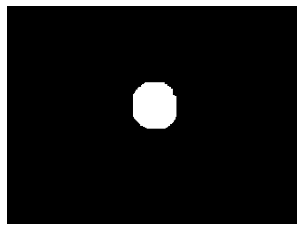

In [35]:
# Morphological operations to clean up the image - remove noise
kernel = np.ones((3,3), np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=10)
plt.imshow(binary, cmap='gray')
plt.axis('off')
plt.show()

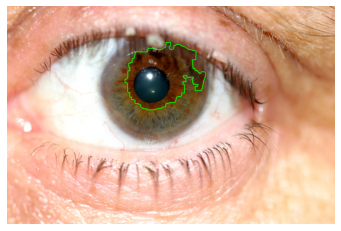

In [28]:
# Plot the binary mask on the original image
# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Find the largest contour
largest_contour = max(contours, key=cv2.contourArea)
# Draw the largest contour
img_copy = img.copy()
cv2.drawContours(img_copy, [largest_contour], -1, (0, 255, 0), 3)
plt.imshow(img_copy)
plt.axis('off')
plt.show()

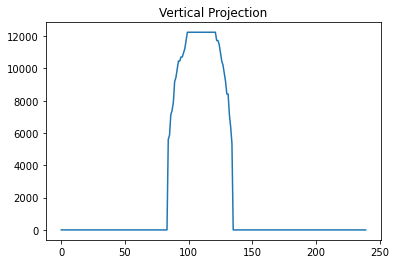

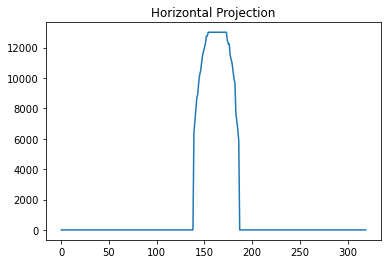

Pupil center: (154, 99)


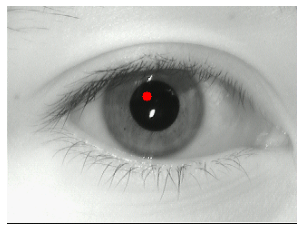

New radius: 25
New center: (162, 109)
Pupil radius: 25


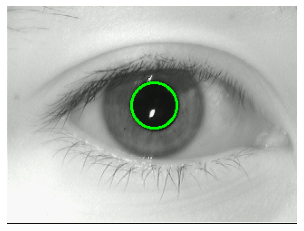

In [36]:
# Projections to find the center of the pupil
h, w = binary.shape
vertical_projection = np.sum(binary, axis=1)
horizontal_projection = np.sum(binary, axis=0)
plt.plot(vertical_projection)
plt.title('Vertical Projection')
plt.show()
plt.plot(horizontal_projection)
plt.title('Horizontal Projection')
plt.show()

# Find the center of the pupil
vertical_center = np.argmax(vertical_projection)
horizontal_center = np.argmax(horizontal_projection)
print(f'Pupil center: ({horizontal_center}, {vertical_center})')

# Draw the center on the original image
img_with_center = img.copy()
cv2.circle(img_with_center, (horizontal_center, vertical_center), 5, (255, 0, 0), -1)
plt.imshow(img_with_center)
plt.axis('off')
plt.show()

# Find the diameter of the pupil by looking in both vertical and horizontal directions
vertical_diameter = 0
for i in range(vertical_center, h):
    if binary[i, horizontal_center] == 0:
        vertical_diameter = i - vertical_center
        v_max = i
        break
for i in range(vertical_center, -1, -1):
    if binary[i, horizontal_center] == 0:
        vertical_diameter += vertical_center - i
        v_min = i
        break

horizontal_diameter = 0
for j in range(horizontal_center, w):
    if binary[vertical_center, j] == 0:
        horizontal_diameter = j - horizontal_center
        h_max = j
        break
for j in range(horizontal_center, -1, -1):
    if binary[vertical_center, j] == 0:
        horizontal_diameter += horizontal_center - j
        h_min = j
        break

# Another way to calculate radius - find v_max, v_min, h_max, h_min of the distribution
vertical_max_freq = vertical_projection[vertical_center]
horizonal_max_freq = horizontal_projection[horizontal_center]
for j in range(vertical_center, h):
    if vertical_projection[j] < vertical_max_freq * 0.2: # 0.2 - to be tuned
        v_max = j
        break
for j in range(vertical_center, -1, -1):
    if vertical_projection[j] < vertical_max_freq * 0.2: # 0.2 - to be tuned
        v_min = j
        break
for j in range(horizontal_center, w):
    if horizontal_projection[j] < horizonal_max_freq * 0.2: # 0.2 - to be tuned
        h_max = j
        break
for j in range(horizontal_center, -1, -1):
    if horizontal_projection[j] < horizonal_max_freq * 0.2: # 0.2 - to be tuned
        h_min = j
        break

new_radius = (v_max - v_min + h_max - h_min) // 4
print(f'New radius: {new_radius}')
new_center = (h_max + h_min) // 2, (v_max + v_min) // 2
print(f'New center: {new_center}')

# Take the average of vertical and horizontal diameters and divide by 2 to get the radius
radius = (vertical_diameter + horizontal_diameter) // 4
print(f'Pupil radius: {radius}')


# Draw the pupil on the original image
img_with_pupil = img.copy()
# cv2.circle(img_with_pupil, (horizontal_center, vertical_center), radius, (0, 255, 0), 2)
cv2.circle(img_with_pupil, new_center, new_radius, (0, 255, 0), 2)

plt.imshow(img_with_pupil)
plt.axis('off')
plt.show()

87210

In [ ]:
# TODO: Taki pomysł jeszcze że można ulepszyć detekcję środka jeszcze bardziej:
# Algorytm:
# 1. Detekcja przez maksimum tak jak teraz
# 2. Szukamy promienia (poprzez r = średnica/2)
# 3. Jako nowy środek bierzemy środek okręgu o promieniu r
# 4. Rysujemy okrąg o nowym środku i promieniu r

# TODO: Dodatkowa walidacja (zabiezpieczenie od katastrofy):
# 1. Na etapie binaryzacji można odrzucać te artefakty które pojawiają się 
# na obwódce obrazu (powiedzmy padding 10-20%)
# 2. Na etapie wyzanczania projekcji można rozpoznawać czy rozkład jest w miarę taki że jest 
# jedno mocne maksimum
# 3. Po wyznaczeniu ostatecznego okręgu sprawdzić jeszcze raz średnią jasność pikesli 
# wewnątrz okręgu i zmniejszyć okrąg jeśli byłaby zbyt jasna


